# Data Creation

In this stage, we convert the connectome and the lineage tree into NetworkX objects, and store them for further processing as graphml files.

In [6]:
!pip3 install joblib

You should consider upgrading via the '/home/apluser/.pyenv/versions/3.9.6/envs/motifs/bin/python3.9 -m pip install --upgrade pip' command.


In [7]:
# !pip3 install networkx numpy pandas git+https://github.com/aplbrain/mossDB tqdm matplotlib seaborn joblib statsmodels

In [34]:
import networkx as nx
from mossdb.client import MossDBClient
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
from tqdm.auto import tqdm

import json
import io
from pathlib import Path
import itertools
from functools import cache

In [40]:
class Config:
        
    def get_lineage_graph():
        lin = nx.json_graph.tree_graph(json.load(Config.LINEAGE_JSON_PATH.open()))
        # Relabel the nodes with the `name` attribute:
        return nx.relabel_nodes(lin, {n: a['name'] for n, a in lin.nodes(data=True)})
    
    def get_connectome():
        fh = io.BytesIO(MossDBClient("http://mossdb").get_file(Config.CONNECTOME_GRAPHML_MOSS_URI))
        c = nx.read_graphml(fh)
        # c = nx.read_graphml(Config.CONNECTOME_GRAPHML_PATH)
        locations = Config.get_cell_locations_map()
        for n in c.nodes:
            try:
                c.nodes[n]['location'] = locations[n]
            except KeyError:
                print(f"Could not find location for neuron [{n}].")
        return c
    
    def get_cell_locations_map():
        return json.load(open(Config.CELL_LOCATION_JSON_PATH, "r"))
    
    def distance_shortest_path(lineage: nx.DiGraph, source: str, target: str):
        """
        Return the shortest path distance between two nodes in a lineage graph.

        Arguments:
            lineage (nx.DiGraph): The target graph
            source (str): The source node
            target (str): The target node
        
        Returns:
            int: The shortest path distance between the source and target nodes

        """
        try:
            return nx.shortest_path_length(nx.Graph(lineage), source, target)
        except:
            return np.nan

    def distance_common_successors(connectome: nx.DiGraph, source: str, target: str):
        """
        Return the number of common successors between two nodes in a connectome graph.

        Arguments:
            connectome (nx.DiGraph): The target graph
            source (str): The source node
            target (str): The target node
        
        Returns:
            int: The number of common successors between the source and target nodes

        """
        try:
            return len(set(connectome.successors(source)).intersection(connectome.successors(target)))
        except Exception as e:
            return np.nan
    
    def distance_euclidean(connectome: nx.DiGraph, source: str, target: str, location_key: str = "location"):
        """
        Return the euclidean distance between two neurons.

        Arguments:
            connectome (nx.DiGraph): The target graph
            source (str): The source node
            target (str): The target node
        
        Returns:
            float: The euclidean distance between the source and target nodes

        """
        try:
            return np.linalg.norm(np.array(connectome.nodes[source][location_key]) - np.array(connectome.nodes[target][location_key]))
        except:
            return np.nan

    LINEAGE_JSON_PATH = Path("./data/bhatla-lineage.json")
    CONNECTOME_GRAPHML_MOSS_URI = "file://graphs/witvliet2020/witvliet_2020_7_node_attributes"
    CONNECTOME_GRAPHML_PATH = Path("./data/witvliet2021-Dataset8.graphml")
    CELL_LOCATION_JSON_PATH = Path("./data/locations.openworm2012.blender.json")

    FOLD_CONNECTOME = True

    LINEAGE_DISTANCE_METRIC = distance_shortest_path
    CONNECTOME_SIMILARITY_METRIC = distance_common_successors
    CONNECTOME_DISTANCE_METRIC = distance_euclidean

    COMPUTE_LINEAGE_DISTANCE_PARALLEL = True
    COMPUTE_CONNECTOME_SIMILARITY_PARALLEL = False
    COMPUTE_CONNECTOME_DISTANCE_PARALLEL = False

In [41]:
def fold_connectome(connectome: nx.DiGraph, prefer_side: str = "R") -> nx.DiGraph:
    """
    Merges all neurons in the connectome that have left (-L) and right (-R)
    counterparts into a single node.

    Arguments:
        connectome (nx.DiGraph): The connectome to fold.
        prefer_side (str: "R"): The side to prefer when folding.
    
    Returns:
        nx.DiGraph: The connectome with the neurons merged.
        
    """
    # Copy the connectome:
    connectome = connectome.copy()

    # Nodes either end in -L or -R:
    # We can collapse all *L into a *R.
    # If the user prefers "L", then collapse all *R into *L.

    non_preferred_side = "L" if prefer_side == "R" else "R"
    for node in connectome.nodes():
        if node.endswith(prefer_side) and f"{node[:-1]}{non_preferred_side}" in connectome:
            # Collapse the two nodes:
            connectome = nx.contracted_nodes(
                connectome, 
                node, f"{node[:-1]}{non_preferred_side}"
            )
    return connectome


In [42]:
LINEAGE = Config.get_lineage_graph()
ORIGINAL_CONNECTOME = Config.get_connectome()
CONNECTOME = fold_connectome(ORIGINAL_CONNECTOME) if Config.FOLD_CONNECTOME else ORIGINAL_CONNECTOME

Could not find location for neuron [BWM-DR04].
Could not find location for neuron [AIZR].
Could not find location for neuron [BWM-DR06].
Could not find location for neuron [BWM-DL05].
Could not find location for neuron [BWM-DR05].
Could not find location for neuron [BWM-DL07].
Could not find location for neuron [BWM-DR01].
Could not find location for neuron [BWM-DL01].
Could not find location for neuron [BWM-DR02].
Could not find location for neuron [BWM-DR03].
Could not find location for neuron [BWM-DL03].
Could not find location for neuron [BWM-VL01].
Could not find location for neuron [BWM-VR01].
Could not find location for neuron [BWM-VL02].
Could not find location for neuron [BWM-DL02].
Could not find location for neuron [BWM-VL04].
Could not find location for neuron [BWM-VL06].
Could not find location for neuron [BWM-VR02].
Could not find location for neuron [BWM-VR03].
Could not find location for neuron [BWM-VL03].
Could not find location for neuron [BWM-VR04].
Could not find lo

## Compute Distances

This is a slow process.

In [43]:
# Compute distances between all nodes in the lineage.


if Config.COMPUTE_LINEAGE_DISTANCE_PARALLEL:
    lineage_distances = {(u, v): res for u, v, res in Parallel(n_jobs=-1)(
        delayed(lambda u, v: (u, v, Config.LINEAGE_DISTANCE_METRIC(LINEAGE, u, v)))(u, v)
        for u, v in tqdm(itertools.product(LINEAGE.nodes, LINEAGE.nodes))
        if u.upper() in CONNECTOME and v.upper() in CONNECTOME
    )}
else:
    lineage_distances = {
        (u, v): Config.LINEAGE_DISTANCE_METRIC(LINEAGE, u, v)
        for u, v in tqdm(itertools.product(LINEAGE.nodes, LINEAGE.nodes))
        if u.upper() in CONNECTOME and v.upper() in CONNECTOME
    }

0it [00:00, ?it/s]

In [44]:
# Compute overlap similarities between all nodes in the connectome.

connectome_similarities = {
    (u, v): Config.CONNECTOME_SIMILARITY_METRIC(CONNECTOME, u, v)
    for u, v in tqdm(itertools.product(CONNECTOME.nodes, CONNECTOME.nodes))
}

0it [00:00, ?it/s]

In [45]:
# Compute neuron distances.

connectome_distances = {
    (u, v): Config.CONNECTOME_DISTANCE_METRIC(CONNECTOME, u, v)
    for u, v in tqdm(itertools.product(CONNECTOME.nodes, CONNECTOME.nodes))
}

0it [00:00, ?it/s]

In [46]:
_all_valid_neuron_pairs = [k for k in connectome_similarities.keys() if k in lineage_distances]

neuron_pairs = pd.DataFrame({
    "u": [k[0] for k in _all_valid_neuron_pairs],
    "u_type": [CONNECTOME.nodes[k[0]]['typ'] for k in _all_valid_neuron_pairs],
    "v": [k[1] for k in _all_valid_neuron_pairs],
    "v_type": [CONNECTOME.nodes[k[1]]['typ'] for k in _all_valid_neuron_pairs],
    "lineage_distance": [lineage_distances[k] for k in _all_valid_neuron_pairs],
    "connectome_similarity": [connectome_similarities[k] for k in _all_valid_neuron_pairs],
    "connectome_distance": [connectome_distances[k] for k in _all_valid_neuron_pairs],
})

neuron_pairs['uv_same_type'] = neuron_pairs.u_type == neuron_pairs.v_type

for t in neuron_pairs.u_type.unique():
    neuron_pairs[f"{t}_match"] = (neuron_pairs.u_type == t) & (neuron_pairs.v_type == t)

## Visualization, Analysis, and Paper Figures

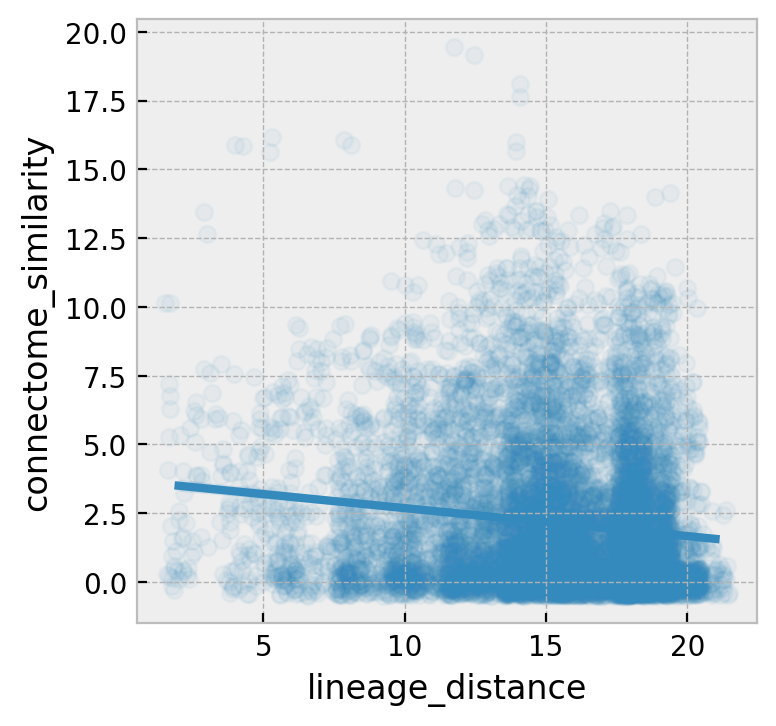

In [47]:
with plt.style.context("bmh"):
    plt.figure(figsize=(4, 4), dpi=200)
    sns.regplot(
        x="lineage_distance",
        y="connectome_similarity",
        data=neuron_pairs[neuron_pairs.u != neuron_pairs.v],
        x_jitter=0.5,
        y_jitter=0.5,
        scatter_kws=dict(alpha=0.05)
    )

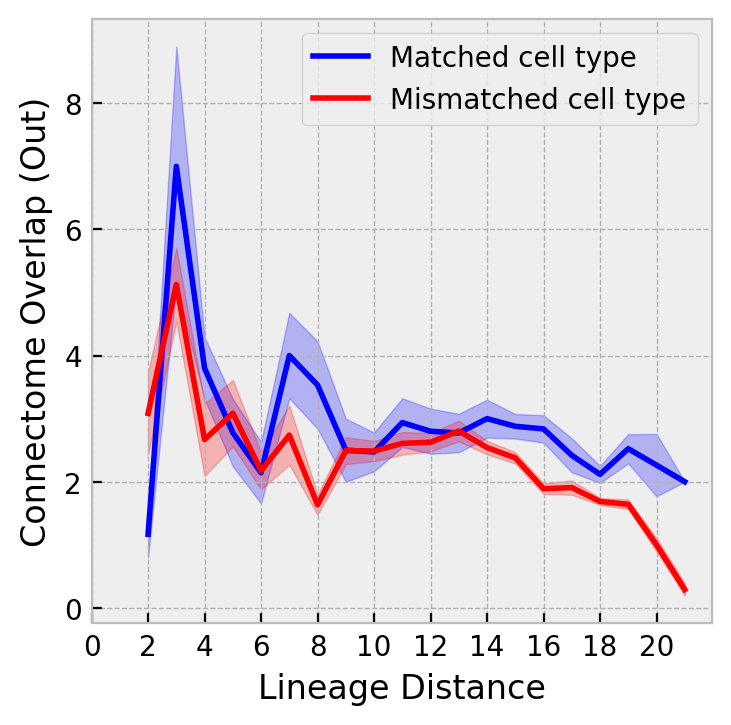

In [48]:
with plt.style.context("bmh"):
    plt.figure(figsize=(4, 4), dpi=200)

    _filtered_groupby = neuron_pairs[
        neuron_pairs.uv_same_type &
        (neuron_pairs.u != neuron_pairs.v)
    ].groupby("lineage_distance")

    sns.lineplot(
        x=_filtered_groupby.groups.keys(), 
        y=_filtered_groupby.mean().connectome_similarity,
        color='b', label="Matched cell type"
    )
    plt.fill_between(
        _filtered_groupby.groups.keys(), 
        _filtered_groupby.mean().connectome_similarity - _filtered_groupby.sem().connectome_similarity,
        _filtered_groupby.mean().connectome_similarity + _filtered_groupby.sem().connectome_similarity,
        alpha=0.25, color='b'
    )


    _filtered_groupby = neuron_pairs[
        ~neuron_pairs.uv_same_type &
        (neuron_pairs.u != neuron_pairs.v)
    ].groupby("lineage_distance")

    sns.lineplot(
        x=_filtered_groupby.groups.keys(), 
        y=_filtered_groupby.mean().connectome_similarity,
        color='r', label="Mismatched cell type"
    )
    plt.fill_between(
        _filtered_groupby.groups.keys(), 
        _filtered_groupby.mean().connectome_similarity - _filtered_groupby.sem().connectome_similarity,
        _filtered_groupby.mean().connectome_similarity + _filtered_groupby.sem().connectome_similarity,
        alpha=0.25, color='r'
    )

    plt.xlabel("Lineage Distance")
    plt.ylabel("Connectome Overlap (Out)")
    plt.xticks(
        range(0, int(max(_filtered_groupby.groups.keys())), 2),
        range(0, int(max(_filtered_groupby.groups.keys())), 2)
    )
    plt.savefig("figs/fig-grouped-distance.png")


## Cell type importances

In [49]:
results = smf.ols(
    formula="connectome_similarity ~ connectome_distance + lineage_distance + " + 
    " + ".join([f"{t}_match" for t in neuron_pairs.u_type.unique()]
), data=neuron_pairs).fit()

In [50]:
results.pvalues

Intercept               0.000000e+00
i_match[T.True]         3.103290e-09
in_match[T.True]        8.319558e-10
sin_match[T.True]       1.456523e-02
sn_match[T.True]        5.743707e-25
s_match[T.True]         2.104110e-05
imn_match[T.True]       1.815262e-04
m_match[T.True]         9.489334e-15
n_match[T.True]         1.627673e-04
sm_match[T.True]        3.714907e-24
im_match[T.True]        7.656466e-04
mn_match[T.True]        5.619884e-38
si_match[T.True]        5.277932e-01
u_match[T.True]         9.420302e-05
connectome_distance     6.010972e-08
lineage_distance       1.481502e-135
dtype: float64

- [ ] do a table of individual coorelations against each feature
- [ ] cosine basis functions (????)
- [ ] predict connectivity with and without; generate a matrix of P(edge)
- [ ] calculate cross entropy between the two; that's the entropy of the lineage tree